In [4]:
import os
import subprocess
import tskit
import msprime
import pyslim

In [5]:
SLIM_SCRIPT = """
    initialize() {{
       setSeed({seed});
       initializeSLiMModelType("nonWF");
       initializeSex("A");
       initializeTreeSeq();
       initializeMutationRate(1e-8);
       initializeMutationType("m1", 0.5, "f", 0.0);
       initializeGenomicElementType("g1", m1, 1.0);
       initializeGenomicElement(g1, 0, 1e8-1);
       initializeRecombinationRate(1e-8);    
       defineConstant("K", 1000);
    }}

    reproduction(p1, "F") {{
       subpop.addCrossed(individual,
                         subpop.sampleIndividuals(1, sex="M"));
    }}

    1 early() {{
       sim.addSubpop("p1", K);
    }}

    early() {{
       p1.fitnessScaling = K / p1.individualCount;
    }}

    1000 late() {{
       sim.treeSeqOutput("/tmp/{name}.trees");
    }}
"""


In [6]:
def slim_func(name, seed):
    """
    Runs a simple simulation from a starting seed, 
    saves a treesequence, loads the finished ts with
    pyslim, and returns the SlimTreeSequence object.
    """
    # write slim script to temp file
    script_path = os.path.join("/tmp", name + ".slim")
    with open(script_path, 'w') as out:
        out.write(SLIM_SCRIPT.format(seed=seed, name=name))
        
    # run slim
    subprocess.run(
        ['slim', script_path], 
        stdout=subprocess.DEVNULL, 
        stderr=subprocess.STDOUT, 
        check=True,
    )
    
    # load the tree sequence
    mts = pyslim.load(f'/tmp/{name}.trees')
    return mts

In [7]:
# simulate 100 gens of selection on a large genome
ts0 = slim_func('ts0', 123)
ts1 = slim_func('ts1', 321)

In [8]:
ts1

In [19]:
# merge the two ts into one ts with 2 populations
merged_ts = pyslim.SlimTreeSequence(
    ts0.union(
        ts1, 
        node_mapping=[tskit.NULL for i in range(ts1.num_nodes)],
        add_populations=True,
    )
)

In [20]:
merged_ts

In [21]:
alive = merged_ts.individuals_alive_at(0)
num_alive = [0 for _ in range(merged_ts.num_populations)]
for i in alive:
   ind = merged_ts.individual(i)
   num_alive[ind.population] += 1

for pop, num in enumerate(num_alive):
   print(f"Number of individuals in population {pop}: {num}")

Number of individuals in population 0: 0
Number of individuals in population 1: 1003
Number of individuals in population 2: 975


In [22]:
demographic_events = [
## merge all individuals into population 1
msprime.MassMigration(
    time = 1000, source = 2, destination = 1, proportion = 1.0)]

In [23]:
# OLD MSPRIME METHOD
pop_configs = [
    msprime.PopulationConfiguration(initial_size=1000)
    for _ in range(merged_ts.num_populations)
]

rts = merged_ts.recapitate(
    population_configurations=pop_configs,
    demographic_events = demographic_events,
    migration_matrix=[
        [0.0, 0.0, 0.0,],
        [0.0, 0.0, 0.0,],
        [0.0, 0.0, 0.0,],
    ],
    recombination_rate=1e-8,
    random_seed=4,
)

In [24]:
rts

In [25]:
mts = pyslim.SlimTreeSequence(msprime.mutate(rts, rate=1e-08, keep=True))

print(f"The tree sequence now has {mts.num_mutations} mutations, "
      f"and mean pairwise nucleotide diversity is {mts.diversity()}.")

The tree sequence now has 132521 mutations, and mean pairwise nucleotide diversity is 6.108630492050024e-05.


In [26]:
pop_indivs = [[], [], []]
pop_nodes = [[], [], []]
for i in mts.individuals_alive_at(0):
   ind = mts.individual(i)
   pop_indivs[ind.population].append(i)
   pop_nodes[ind.population].extend(ind.nodes)

diversity = mts.diversity(pop_nodes[1:])
divergence = mts.divergence(pop_nodes[1:], indexes=[(0,1)])

print(f"There are {mts.num_mutations} mutations across {mts.num_trees} distinct "
      f"genealogical trees describing relationships among {mts.num_samples} "
      f"sampled genomes, with a mean genetic diversity of {diversity[0]} and "
      f"{diversity[1]} within the two populations, and a mean divergence of "
      f"{divergence[0]} between them.")

There are 132521 mutations across 40532 distinct genealogical trees describing relationships among 3956 sampled genomes, with a mean genetic diversity of 5.530153367826999e-05 and 5.481712934179901e-05 within the two populations, and a mean divergence of 6.710578989185738e-05 between them.


## Simplifying Tree Sequence
a basic tree sequence output by SLiM only contains the currently alive individuals and the ancestral nodes (genomes) required to reconstruct their genetic relationships

In [27]:
pop1 = []
pop2 = []
inds = mts.individuals()
for i in range(1, inds.length):
    if inds[i].population == 1:
        pop1.append(inds[i].id)
    elif inds[i].population == 2:
        pop2.append(inds[i].id)

In [28]:
import numpy as np
np.random.seed(3)
p1_keep_indivs = np.random.choice(pop1, 10, replace=False)
p2_keep_indivs = np.random.choice(pop2, 10, replace=False)
keep_nodes1 = []
keep_nodes2 = []

for i in p1_keep_indivs:
   keep_nodes1.extend(mts.individual(i).nodes)
sts_p1 = mts.simplify(keep_nodes1, keep_input_roots=True)

for i in p2_keep_indivs:
   keep_nodes2.extend(mts.individual(i).nodes)
sts_p2 = mts.simplify(keep_nodes2, keep_input_roots=True)

print(f"Before, there were {rts.num_samples} sample nodes (and {rts.num_individuals} individuals) "
       f"in the tree sequence, and now there are {sts_p1.num_samples} sample nodes "
       f"(and {sts_p1.num_individuals} individuals) in p1 and {sts_p2.num_samples} sample nodes "
       f"(and {sts_p2.num_individuals} individuals) in p2.")

Before, there were 3956 sample nodes (and 1978 individuals) in the tree sequence, and now there are 20 sample nodes (and 10 individuals) in p1 and 20 sample nodes (and 10 individuals) in p2.


In [29]:
sts_p1


In [30]:
sts_p2

In [31]:
np.random.seed(3)
p1_keep_indivs = np.random.choice(pop1, 10, replace=False)
p2_keep_indivs = np.random.choice(pop2, 10, replace=False)
keep_indivs = np.concatenate((p2_keep_indivs, p1_keep_indivs), axis=None)
keep_nodes = []

for i in keep_indivs:
   keep_nodes.extend(mts.individual(i).nodes)
sts = mts.simplify(keep_nodes, keep_input_roots=True)

print(f"Before, there were {rts.num_samples} sample nodes (and {rts.num_individuals} individuals) "
       f"in the tree sequence, and now there are {sts_p1.num_samples} sample nodes "
       f"(and {sts_p1.num_individuals} individuals).")

Before, there were 3956 sample nodes (and 1978 individuals) in the tree sequence, and now there are 20 sample nodes (and 10 individuals).


In [32]:
sts

In [33]:
sts.individuals_alive_at(0)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

In [34]:
sts_sample_sets = [[0,  1,  2,  3,  4,  5,  6,  7,  8,  9],[10, 11, 12, 13, 14, 15, 16,
       17, 18, 19]]

In [53]:
sts.individual(1).population

0

In [58]:
set1 = []
set2 = []
for i in sts.individuals_alive_at(0):
    if sts.individual(i).population == 0:
        set1.append(i)
    else:
        set2.append(i)
sets = [set1, set2]
sets

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9], [10, 11, 12, 13, 14, 15, 16, 17, 18, 19]]

In [36]:
sts.diversity(sts_sample_sets)

array([5.45002222e-05, 5.52695556e-05])

In [37]:
sts.divergence(sts_sample_sets)

array(5.44498e-05)

In [38]:
sts.allele_frequency_spectrum()

array([0.0000e+00, 1.6459e-04, 6.2100e-05, 3.7830e-05, 2.3530e-05,
       1.6170e-05, 1.2380e-05, 9.1600e-06, 7.6100e-06, 6.7200e-06,
       6.0800e-06, 5.6700e-06, 5.2500e-06, 4.8600e-06, 4.1700e-06,
       5.0500e-06, 4.2800e-06, 4.6200e-06, 3.9400e-06, 3.7100e-06,
       2.0800e-06, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
       0.0000e+00])

In [39]:
sts.Fst(sts_sample_sets)

array(-0.00397942)

In [40]:
sts.Tajimas_D(sts_sample_sets)

array([-0.39928979, -0.46996282])

In [41]:
#print(sts.draw_text()) # -- Good for <20 nodes

In [42]:
from IPython.display import display, SVG
svg_size = (800, 250) # Height and width for the SVG: optional but useful for this notebook
svg_string = sts.draw_svg(
    size=svg_size,
    x_scale="treewise",  # Match the axis coordinate systems to the text view
)
display(SVG(svg_string))  # If the last line in a cell, wrapping this in display() is not needed

KeyboardInterrupt: 

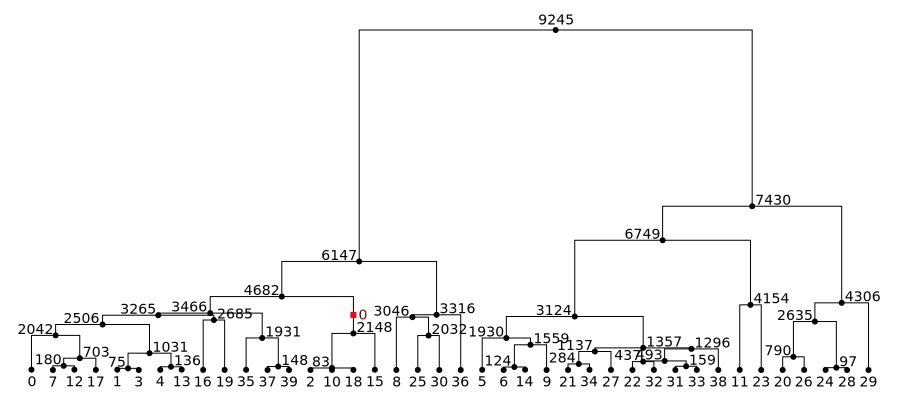

In [43]:
display(SVG(sts.at_index(2).draw_svg(size = (900,400))))

In [ ]:
display(SVG(sts.at_index(2).draw_svg(size = (900,400), all_edge_mutations=True)))

In [1]:
species = [1, 2, 3]

In [14]:
msprime.mutate??

In [59]:
files = ["1", "2"]

In [62]:
files.

<function list.count(value, /)>